## Reproducible file accompanying the paper
# OPTIMAL RECOVERY FROM INACCURATE DATA IN HILBERT SPACES: REGULARIZE, BUT WHAT OF THE PARAMETER?
By S. Foucart and C. Liao.

This reproducible was written by S. Foucart and C. Liao in November 2021.

CVXPY [2] is required to execute this reproducible.

In [1]:
import numpy as np
from scipy import linalg as LA
import cvxpy as cp
import matplotlib.pyplot as plt

## L1: Locally optimal recovery in a complex Hilbert space with arbitrary observations

WIth $H$ restricted to be a complex finite-dimensional Hilbert space, the Chebyshev center of the set $\{f\in H:\|P_{\mathcal{V}^\perp}f\|\leq \varepsilon, \|\Lambda f-y\|\leq\eta\}$ is the solution $f_\tau$ to

$$ \mathop{\mathrm{minimize}}\limits_{f\in H} \quad (1-\tau)\|P_{\mathcal{V}^\perp}f\|^2+\tau\|\Lambda f-y\|^2$$

for the choice $\tau = d_\#/(c_\#+d_\#)$, where $c_\#, d_\#$ solve the semidefinite program

\begin{align*}
\mathop{\mathrm{minimize}}\limits_{c,d,t\geq0} \; \varepsilon^2c+(\eta^2-\|y\|^2)d+t \quad & \mbox{s.to} \quad cP_{\mathcal{V}^\perp}+d\Lambda^*\Lambda\succeq\mathrm{Id} \\ 
& \mbox{and} \quad  \left[\matrix{ c P_{\mathcal{V}^\perp} + d \Lambda^* \Lambda & | & -d \Lambda^* y 
\cr
\hline
-d(\Lambda^* y)^*  & | & t }\right]
\succeq 0.
\end{align*}

### Problem setting

In [2]:
# dimension of the ambient Hilbert space
N = 20
# dimension of the approximation subspace
n = 5
# subspace spanned by the columns of V
V = np.random.randn(N,n) + np.random.randn(N,n) * 1j
# projector onto the orthogonal complement of V
P1 = np.identity(N) - V@LA.inv(np.conjugate(V.T)@V)@np.conjugate(V.T)
# the approximability parameter
epsilon = 0.1
# number of observations
m = 10
# the observation map (we use L instead of \Lambda)
L = np.random.randn(m,N) + np.random.randn(m,N) * 1j
# the uncertainty parameter
eta = 0.5                   
# the original f and of its observation vector
aux = np.random.randn(N,1)
f = V@np.random.rand(n,1)+(epsilon/2)*aux/LA.norm(aux)
# the inaccurate observations
aux = np.random.randn(m,1)
y = L@f + (2*eta/3)*aux/LA.norm(aux)

### Computation of optimal parameters, Chebyshev centers, and local worst-case errors

In [3]:
# A function named BE (for Beck and Eldar) is defined here.
# It returns the optimal parameter tau, the Chebyshev center, and the local worst-case error
def BE(epsilon,eta,y,P,L):
    N = np.shape(P)[0]
    L_star = np.conjugate(L.T)
    c = cp.Variable((1,1),nonneg=True)
    d = cp.Variable((1,1),nonneg=True)
    t = cp.Variable((1,1),nonneg=True)
    objective = cp.Minimize(c*epsilon**2+d*(eta**2-LA.norm(y)**2)+t)
    a11 = cp.multiply(c,P)+cp.multiply(d,L_star@L)
    a12 = -cp.multiply(d,L_star@y) 
    constraints = [cp.multiply(c,P)+cp.multiply(d,L_star@L)-np.identity(N)>>0]
    constraints += [ cp.vstack( (cp.hstack((a11, a12)),cp.hstack((cp.conj(a12).T,t))) )>>0]
    local = cp.Problem(objective,constraints)
    local.solve()
    c = c.value[0,0]
    d = d.value[0,0]
    tau = d/(c+d)
    cheb_center = LA.solve(c*P+d*L_star@L,d*L_star@y)
    wce = np.sqrt(c*epsilon**2-d*(LA.norm(y)**2-eta**2)+t.value[0,0])
    return tau,cheb_center,wce

In [4]:
tau,cheb_center,local_wce = BE(epsilon,eta,y,P1,L)
print('With H being a complex finite-dimensional Hilbert space,\n ' 
      'the optimal parameter tau is {:.3f} and \n '
      'the corresponding worst-case error is {:.3f}.'.format(tau,local_wce))

With H being a complex finite-dimensional Hilbert space,
 the optimal parameter tau is 0.015 and 
 the corresponding worst-case error is 0.566.


/Users/foucart/opt/anaconda3/lib/python3.8/site-packages/cvxpy/problems/problem.py:1294: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


### Verification: the Chebyshev center does not depend linearly on y
The locally optimal recovery map $\mathrm{Cheb}:\mathbb{R}^m\to H$ that sends $y\in\mathbb{R}^m$ to the Chebyshev center of the above set is not linear.

To check it numerically, we illustrate that $2 \,\mathrm{Cheb}(y)\neq\mathrm{Cheb}(2 y)$.

In [5]:
_,cheb_center_2y,_ = BE(epsilon,eta,2*y,P1,L)
print('The norm of the difference 2*Cheb(y)-Cheb(2*y) '
      'is {:.3f} (not zero).'.format(LA.norm(2*cheb_center-cheb_center_2y)))

The norm of the difference 2*Cheb(y)-Cheb(2*y) is 0.035 (not zero).


## L2: Locally optimal recovery map in real Hilbert space with orthonormal observations

Under the orthonormal observations assumptions ($\Lambda^*\Lambda = \mathrm{Id}_{\mathbb{R}^m}$) but without the restriction that $H$ is a complex Hilbert space, the Chebyshev center of the set $\{f\in H:\|P_{\mathcal{V}^\perp}f\|\leq\epsilon, \|\Lambda f-y\|\leq\eta\}$ is the solution $f_{\tau_\#}$ to

$$ \mathop{\mathrm{minimize}}\limits_{f\in H} \quad (1-\tau_\#)\|P_{\mathcal{V}^\perp}f\|^2+\tau_\#\|\Lambda f-y\|^2$$

for the choice $\tau_\#$ of parameter $\tau$ between $1/2$ and $\varepsilon/(\varepsilon+\eta)$ that satisfies

$$ \lambda_{\min} ((1-\tau)P_{\mathcal{V}^\perp} + \tau \Lambda^* \Lambda)
= \frac{(1-\tau)^2 \varepsilon^2 - \tau^2 \eta^2}{(1-\tau) \varepsilon^2 - \tau \eta^2 + (1-\tau) \tau (1-2 \tau)  \delta^2},
$$

where $\delta$ is precomputed as $\delta = \min\{ \|P_{\mathcal{V}^\perp}f\|: \Lambda f = y \} = \min \{ \|\Lambda f - y\|: f \in \mathcal{V} \}$.

With $\lambda_\# := \lambda_\min((1-\tau_\#)P_{\mathcal{V}^\perp}+\tau_\#\Lambda^*\Lambda)$, the squared Chebyshev radius (squared local worst-case error) is $\dfrac{1-\tau_\#}{\lambda_\#}\varepsilon^2 + \dfrac{\tau_\#}{\lambda_\#}\eta^2 - \dfrac{(1-\tau_\#)\tau_\#}{\lambda_\#}\delta^2$.

### Problem setting
We adopt the same problem setting as before, with the difference that the orthonormal observations assumption is in effect here.

In [6]:
N = 50
n = 15
V = np.random.randn(N,n)
epsilon = 0.5
m = 25
L = np.random.randn(m,N)
L = LA.inv(LA.sqrtm(L@L.T))@L            # so that L satisfies L*L'=I
eta = 0.2
aux = np.random.randn(N,1)
f = V@np.random.rand(n,1)+(epsilon/2)*aux/LA.norm(aux)
aux = np.random.randn(m,1)
y = L@f + (2*eta/3)*aux/LA.norm(aux)

### Some useful objects

In [7]:
P1 = np.identity(N) - V@LA.inv(V.T@V)@V.T    # orthogonal projector onto the orthogonal complement of V
P2 = L.T@L                                   # orthogonal projector onto the range of L'
C = L@V                                      # cross-gramian (see the appendix)
b = LA.inv(C.T@C)@(C.T@y)
a = y - C@b
f_0 = V@b                                    # the regularized solution corresponding to tau=0
f_1 = L.T@a + V@b                            # the regularized solution corresponding to tau=1
delta = LA.norm(f_0-f_1)                     # the parameter in the implicit equation defining tau_#
delta_0 = LA.norm(L@f_0-y)                   # a second way to calculate delta
delta_1 = LA.norm(P1@f_1)                    # a third way to calculate delta
print('As they should, the three ways to calculate delta return '
      'the same values: {:.3f}, {:.3f}, and {:.3f}.'.format(delta,delta_0,delta_1))

As they should, the three ways to calculate delta return the same values: 0.170, 0.170, and 0.170.


### Newton method for finding the optimal parameter
We devise below our own Newton method to solve the equation implicitly defining the parameter $\tau_\#$.

In [8]:
# the smallest eigenvalue as a function of t
def eigen(t):
    return LA.eigh((1-t)*P1+t*P2, eigvals_only=True)[0]

# the numerator of the fraction in the RHS and its derivative
def nume(t):
    return (1-t)**2*epsilon**2 - t**2*eta**2

def diff_nume(t):
    return -2*(1-t)*epsilon**2 - 2*t*eta**2

# the denominator of the fraction in the RHS and its derivative
def denom(t):
    return (1-t)*epsilon**2 - t*eta**2 + (1-t)*t*(1-2*t)*delta**2

def diff_denom(t):
    return -epsilon**2 - eta**2 + (1-6*t+6*t**2)*delta**2

# define the funtion F and its derivative
def F(t):
    return eigen(t) - nume(t)/denom(t)

def diff_F(t):
    return ( (1-2*t)/t/(1-t)*eigen(t)*(1-eigen(t))/(1-2*eigen(t)) 
            - (diff_nume(t)*denom(t)-diff_denom(t)*nume(t))/denom(t)**2 )
    
# Find the optimal parameter tau (the zero of F)
tau = epsilon/(epsilon+eta)
iteration = 25
for i in range(iteration):
    tau = tau - F(tau)/diff_F(tau)
    
# For comparison, use Python built-in function to find the zero of F
from scipy import optimize
tau_builtin = optimize.root_scalar(F, x0=0.5, x1=epsilon/(epsilon+eta), method='secant').root

# Compare also with the output of the method from Beck and Eldar
# (not guaranteed to yield the optimal parameter in real setting)
tau_BE,_,wce_BE = BE(epsilon,eta,y,P1,L)

In [9]:
print('With H being a real finite-dimensional Hilbert space and using orthonormal observations,\n '
     'our custom Newton method provides the optimal tau equal to {:.3f},\n '
     'the Python built-in function yields the parameter equal to {:.3f},\n '
     'and the method of Beck--Eldar returns a parameter equal to {:.3f}.'.format(tau,tau_builtin,tau_BE))

With H being a real finite-dimensional Hilbert space and using orthonormal observations,
 our custom Newton method provides the optimal tau equal to 0.711,
 the Python built-in function yields the parameter equal to 0.711,
 and the method of Beck--Eldar returns a parameter equal to 0.711.


In [10]:
lwce_square = (1-tau)/eigen(tau)*epsilon**2 + tau/eigen(tau)*eta**2 - (1-tau)*tau/eigen(tau)*delta**2
print('The formula for the local worst-case error gives the value {:.3f},\n '
     'which also agrees with the value {:.3f} returned by the method of Beck--Eldar.'.format(np.sqrt(lwce_square),wce_BE))

The formula for the local worst-case error gives the value 2.324,
 which also agrees with the value 2.324 returned by the method of Beck--Eldar.


### Distinct case: $\mathcal{V}=\{0\}$
For the distinct case $\mathcal{V}=\{0\}$, the optimal choice of parameter is simply $\tau_\# = \max\{1-\eta/\|y\|,0\}$.

In [11]:
N = 10
P1 = np.identity(N)
epsilon = 0.1
m = 6
L = np.random.randn(m,N)
L = LA.inv(LA.sqrtm(L@L.T))@L            # so that L satisfies L*L'=I
eta = 0.2
aux = np.random.randn(N,1)
f = epsilon*aux/LA.norm(aux)
aux = np.random.randn(m,1)
y = L@f + eta*aux/LA.norm(aux)
if LA.norm(y)<= eta:
    opt_tau = 0
    print('The norm of y is {:.3f}, which is smaller than or equal to eta,'
         ' so the optimal parameter is 0.'.format(LA.norm(y)))
else:
    opt_tau = 1-eta/LA.norm(y)
    print('The norm of y is {:.3f}, which is greater than eta,'
         ' so the optimal parameter is {:.3f}.'.format(LA.norm(y),opt_tau))

The norm of y is 0.248, which is greater than eta, so the optimal parameter is 0.195.


In [12]:
# Here too, the method of Beck--Eldar seems to give the correct parameter
tau_BE,_,_ = BE(epsilon,eta,y,P1,L)
print('The parameter obtained after solving the semidefinite program of Beck--Eldar is {:.3f},\n '
     'which agrees with the value of the optimal parameter given by the above formula.'.format(tau_BE))

The parameter obtained after solving the semidefinite program of Beck--Eldar is 0.195,
 which agrees with the value of the optimal parameter given by the above formula.


## G1: Globally optimal recovery with arbitrary observations

For any $\tau\in(0,1)$, let $\Delta:\mathbb{R}^m\to H$ denote the recovery map based on regularization with parameter $\tau$, so that $\Delta_\tau(y) = ((1-\tau)P_{\mathcal{V}^\perp}+\tau \Lambda^*\Lambda)^{-1}(\tau \Lambda^*y)$. 
The global worst-case error of $\Delta_\tau$ is upper bounded as 

\begin{align*}
\mathrm{gwce}(\Delta_\tau)^2 \leq &\min\limits_{c,d\geq0} c\varepsilon^2+d\eta^2 \\ 
&\mbox{s.to} \quad
\left[\matrix{
c P_{\mathcal{V}^\perp} & | & 0
\cr \hline
0 & | & d \, \mathrm{Id}_{\mathbb{R}^m}}\right]
\succeq  \left[\matrix{\mathrm{Id} - \Lambda^* \Delta_\tau^* \cr \hline \Delta_\tau^*}\right]
\left[\matrix{ \mathrm{Id} - \Delta_\tau \Lambda \; | \; \Delta_\tau}\right].
\end{align*}

It is also lower-bounded as 
$$ 
\mathrm{gwce}(\Delta_\tau)^2 \geq \mathop{\mathrm{minimize}}\limits_{c,d \ge 0} \; \varepsilon^2 c + \eta^2 d
\qquad \mbox{s.to}  \quad
c P_{\mathcal{V}^\perp} + d \Lambda^* \Lambda \succeq \mathrm{Id}. $$

The upper and lower bounds agree at the parameter $\tau = d/(c+d)$, where $c,d$ are solutions to the latter semidefinite program.

### Program setting
We adopt the same problem setting as before

In [13]:
N = 50
n = 15
V = np.random.rand(N,n)
P1 = np.identity(N) - V@LA.inv(V.T@V)@V.T
epsilon = 0.4
m = 25
L = np.random.randn(m,N)
eta = 0.3

### Illustration of the agreement between the upper and lower bounds at the optimal parameter
We compute the lower bound first.

In [14]:
c = cp.Variable((1,1),nonneg=True)
d = cp.Variable((1,1),nonneg=True)
objective = cp.Minimize(c*epsilon**2+d*eta**2)
constraints = [cp.multiply(c,P1)+cp.multiply(d,L.T@L)-np.identity(N)>>0]
G1 = cp.Problem(objective,constraints)
G1.solve()
c = c.value[0,0]
d = d.value[0,0]
lower_bound = np.sqrt(c*epsilon**2+d*eta**2)
opt_tau = d/(c+d)

Next, we compute the upper bounds on a grid of values of $\tau\in(0,1)$.

In [15]:
T = 99
range_tau = np.linspace(0.01,0.99,T)
upper_bound = np.zeros(T)
for i in range(T):
    tau = range_tau[i]
    Delta_tau = tau*LA.inv((1-tau)*P1+tau*L.T@L)@L.T
    c = cp.Variable((1,1),nonneg=True)
    d = cp.Variable((1,1),nonneg=True)
    objective = cp.Minimize(c*epsilon**2+d*eta**2)
    a11 = cp.multiply(c,P1) - (np.identity(N)-L.T@Delta_tau.T)@(np.identity(N)-Delta_tau@L)
    a12 = -(np.identity(N)-L.T@Delta_tau.T)@Delta_tau
    a22 = d*np.identity(m) - Delta_tau.T@Delta_tau
    constraints = [ cp.vstack( (cp.hstack((a11, a12)),cp.hstack((a12.T,a22))) )>>0]
    G1 = cp.Problem(objective,constraints)
    G1.solve()
    c = c.value[0,0]
    d = d.value[0,0]
    upper_bound[i] = np.sqrt(c*epsilon**2+d*eta**2)

Finally, we visualize the lower bound as well as the upper bounds parametrized by $\tau$.

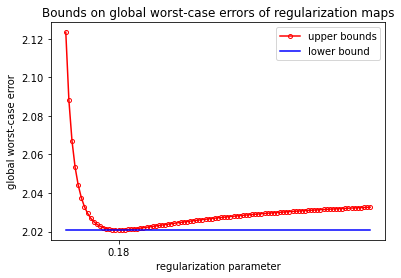

In [16]:
plt.plot(range_tau,upper_bound,'r-o',range_tau,lower_bound*np.ones(T),'b-',markerfacecolor='none',markersize=4)
plt.legend(['upper bounds','lower bound'])
plt.title('Bounds on global worst-case errors of regularization maps')
plt.ylabel('global worst-case error')
plt.xlabel('regularization parameter')
plt.xticks(ticks=[opt_tau])
plt.show()

## G2: Globally optimal recovery with orthonormal observations

Under the orthonormal observations assumption ($\Lambda^*\Lambda=\mathrm{Id}_{\mathbb{R}^m}$), all the regularization maps $\Delta_\tau$ turn out to be globally optimal.

To illustrate this numerically, we study the global worst-case error $\mathrm{gwce}(\Delta_\tau)$ by computing a lower bound and upper bounds on a grid of values $\tau\in[0,1]$, as in G1 above.
We also compare these values to the theoretical value of the global worst-case error, which is 

$$ \mathrm{gwce} = \frac{1-\tau_\#}{\lambda_\#}\varepsilon^2 + \frac{\tau_\#}{\lambda_\#}\eta^2,$$

where $\lambda_\# := \lambda_\min((1-\tau_\#)P_{\mathcal{V}^\perp}+\tau_\#\Lambda^*\Lambda)$ and $\tau_\#$ is the parameter $\tau$ between $1/2$ and $\varepsilon/(\varepsilon+\eta)$ that satisfies

$$ \lambda_\min((1-\tau)P_{\mathcal{V}^\perp}+\tau\Lambda^*\Lambda) = \frac{(1-\tau)^2\varepsilon^2-\tau^2\eta^2}{(1-\tau)\varepsilon^2-\tau\eta^2}. 
$$

### Problem setting
We adopt the same problem setting as before.

In [17]:
N = 50
n = 15
V = np.random.rand(N,n)
epsilon = 0.4
m = 25
L = np.random.randn(m,N)
L = LA.inv(LA.sqrtm(L@L.T))@L
eta = 0.3
P1 = np.identity(N) - V@LA.inv(V.T@V)@V.T
P2 = L.T@L
C = L@V
C_linv = LA.inv(C.T@C)@C.T
Delta_0 = V@C_linv
Delta_1 = L.T - L.T@C@C_linv + V@C_linv

### Verification that all bounds coincide with the theoretical value of the global worst-case error
We compute the lower bound first.

In [18]:
c = cp.Variable((1,1),nonneg=True)
d = cp.Variable((1,1),nonneg=True)
objective = cp.Minimize(c*epsilon**2+d*eta**2)
constraints = [cp.multiply(c,P1)+cp.multiply(d,L.T@L)-np.identity(N)>>0]
G1 = cp.Problem(objective,constraints)
G1.solve()
c = c.value[0,0]
d = d.value[0,0]
lower_bound = np.sqrt(c*epsilon**2+d*eta**2)

Next, we compute the upper bounds on a grid of values of $\tau\in[0,1]$.

In [19]:
T = 101
range_tau = np.linspace(0,1,T)
upper_bound = np.zeros(T)
for i in range(T):
    tau = range_tau[i]
    Delta_tau = (1-tau)*Delta_0 + tau*Delta_1
    c = cp.Variable((1,1),nonneg=True)
    d = cp.Variable((1,1),nonneg=True)
    objective = cp.Minimize(c*epsilon**2+d*eta**2)
    a11 = cp.multiply(c,P1) - (np.identity(N)-L.T@Delta_tau.T)@(np.identity(N)-Delta_tau@L)
    a12 = -(np.identity(N)-L.T@Delta_tau.T)@Delta_tau
    a22 = d*np.identity(m) - Delta_tau.T@Delta_tau
    constraints = [ cp.vstack( (cp.hstack((a11, a12)),cp.hstack((a12.T,a22))) )>>0]
    G2 = cp.Problem(objective,constraints)
    G2.solve()
    c = c.value[0,0]
    d = d.value[0,0]
    upper_bound[i] = np.sqrt(c*epsilon**2+d*eta**2)

Finally, we calculate the theoretical value of the global worst-case error and verify that the previous bounds are all equal to this theoretical value.

In [20]:
def F_G2(t):
    return eigen(t)-((1-t)**2*epsilon**2-t**2*eta**2)/((1-t)*epsilon**2-t*eta**2)

tau = optimize.root_scalar(F_G2, x0=0.5, x1=epsilon/(epsilon+eta), method='secant').root
lambda_sharp = eigen(tau)
gwce = np.sqrt((1-tau)*epsilon**2/lambda_sharp + tau*eta**2/lambda_sharp)

print('The lower bound, upper bounds, and theoretical values are all the same, precisely:')
print('the lower bound equals to {:.3f}, \n'
     'the maximal upper bound is {:.3f}, \n'
     'and the theoretical value is {:.3f}.'.format(lower_bound,max(upper_bound),gwce))

The lower bound, upper bounds, and theoretical values are all the same, precisely:
the lower bound equals to 3.199, 
the maximal upper bound is 3.199, 
and the theoretical value is 3.199.


## References 

[1] S. Foucart and C. Liao, "Optimal recovery from inaccurate data in Hilbert spaces: regularize, but what of the parameter?", Preprint.

[2] S. Diamond and S. Boyd, "CVXPY: A Python-embedded modeling language for convex optimization", Journal of Machine Learning Research, 17(83):1–5, 2016.